### Empirical Example for RobustiPY (Type 1)!

#### This example is designed to show how basic functionality -- such as OLS can be used with a cross-sectional dataset -- works.

This notebook demonstrates how to use RobustiPY for robust regression analysis with a cross-sectional dataset. It includes downloading data, running OLS regressions, and leveraging RobustiPY's robust regression capabilities.

In [1]:
import requests
import zipfile
import io
import os
import pandas as pd
import statsmodels.formula.api as smf
from robustipy.models import OLSRobust

import warnings
from robustipy.prototypes import MissingValueWarning

# Ignore all MissingValueWarning warnings from robustipy
warnings.filterwarnings(
    action="ignore",
    category=MissingValueWarning,
    module=r"robustipy\.prototypes"
)



Here we are downloading a zip file containing the dataset `maketable2.zip` from Dropbox. This dataset will be used for our regression analysis. The file will be extracted and processed in subsequent steps to prepare it for analysis.

In [2]:
url = "https://www.dropbox.com/s/1s1yb7a3hkjwzjh/maketable2.zip?dl=1"
response = requests.get(url)
response.raise_for_status()


### Extracting the Dataset

In the following steps, we create a directory to store the dataset and extract the contents of the downloaded zip file into this directory. This ensures that the dataset is organized and ready for further processing. The extracted files will be used in subsequent steps for loading and analysis.


In [3]:
os.makedirs('../data/acemoglu_example', exist_ok=True)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall('../data/acemoglu_example')

Now we load the data into a pandas dataframe

In [4]:
df = pd.read_stata('../data/acemoglu_example/maketable2.dta')

Here we are defing a helper function to run and display OLS from `statmodels` with robust SEs to see how this compares witht he results of `robustipy`:

In [5]:
def run_regression(formula, data, label):
    model = smf.ols(formula, data=data).fit(cov_type='HC1')
    print(f"\n--- Column {label} ---")
    print(model.summary())

Ane now we execute each column's regression:

In [6]:
run_regression('logpgp95 ~ avexpr', df, 1)
run_regression('logpgp95 ~ avexpr', df[df['baseco'] == 1], 2)
run_regression('logpgp95 ~ avexpr + lat_abst', df, 3)
run_regression('logpgp95 ~ avexpr + lat_abst + africa + asia + other', df, 4)
run_regression('logpgp95 ~ avexpr + lat_abst', df[df['baseco'] == 1], 5)
run_regression('logpgp95 ~ avexpr + lat_abst + africa + asia + other', df[df['baseco'] == 1], 6)
run_regression('loghjypl ~ avexpr', df, 7)
run_regression('loghjypl ~ avexpr', df[df['baseco'] == 1], 8)


--- Column 1 ---
                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     334.8
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           5.14e-35
Time:                        11:54:02   Log-Likelihood:                -119.71
No. Observations:                 111   AIC:                             243.4
Df Residuals:                     109   BIC:                             248.8
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6261      0.241  

Now allow `robustipy` to run all possible combination of controls variables, not just a selected subset.

In [7]:
acemoglu_robust = OLSRobust(y=['logpgp95'], x=['avexpr'], data=df)
acemoglu_robust.fit(controls=['lat_abst', 'africa', 'asia', 'other'],
                    draws=1000,
                    kfold=10,
                    seed=192735,
                    oos_metric='pseudo-r2',
                    threshold=1000000)

You haven’t specified the number of CPUs. Is 31 okay? (yes/no):  yes


Output()

OLSRobust is running with n_cpu=31, draws=1000, folds=10, seed=192735.
We're evaluating our out-of-sample predictions with the pseudo-r2 metric.
The estimand of interest is avexpr. Let's begin the calculations...
Total model runs: 16,000 (draws=1000, control_specs=16, y_composites=1)


We get the results:

In [8]:
acemoglu_robust_results = acemoglu_robust.get_results()

An we plot:

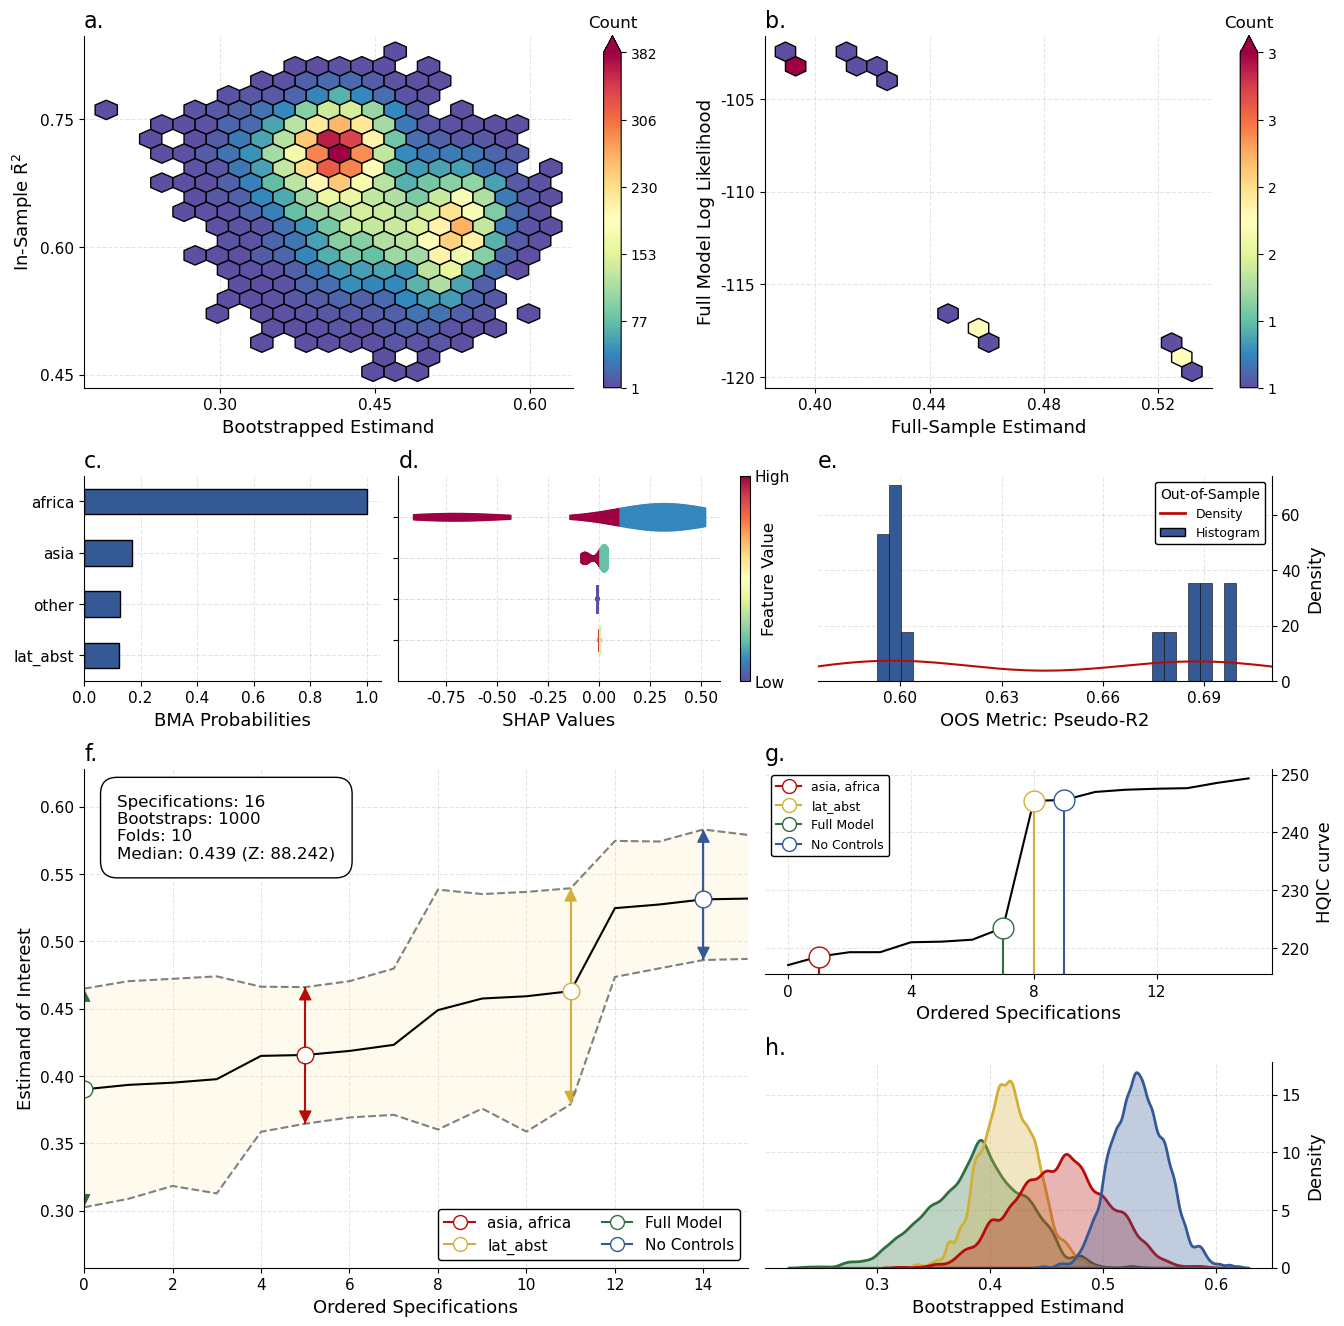

In [9]:
acemoglu_robust_results.plot(specs=[['lat_abst'], ['africa', 'asia']],
                             ic='hqic',
                             ext='pdf',
                             ci=0.95,
                             loess=False,figpath = '../figures',
                             project_name='acemoglu_example',
                             figsize=(16, 16)
                            )

We can also get a nice handy summary of the results:

In [10]:
acemoglu_robust_results.summary(digits=2)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: logpgp95
Independent variable: avexpr
Number of possible controls: 4
Number of draws: 1000
Number of folds: 10
Number of specifications: 16
2.Model Robustness Metrics
2.1 Inference Metrics
Median β (specs, no resampling): 0.44 (null-calibrated p: 0)
Median β (bootstraps × specs): 0.44
Min β (specs, no resampling): 0.39
Min β (bootstraps × specs): 0.19
Max β (specs, no resampling): 0.53
Max β (bootstraps × specs): 0.62
AIC-weighted β (specs, no resampling): 0.40
BIC-weighted β (specs, no resampling): 0.42
HQIC-weighted β (specs, no resampling): 0.41
Share significant (specs, no resampling) [descriptive]: 1.00
Share significant (bootstraps × specs) [descriptive]: 1.00  |  null-calibrated p: 0.002
Share β>0 (specs, no resampling) [descriptive]: 1.00
Share β>0 (bootstraps × specs) [descriptive]: 1.00  |  null-calibrated p: 0.002
Share β<0 (specs, no resampling) [descriptive]: 0.00
Share β<0 (bootstraps × specs) [de

Lets do this again, but now with a constant into the x-array.

In [11]:
df['constant'] = 1

In [12]:
acemoglu_robust_wc = OLSRobust(y=['logpgp95'], x=['avexpr'], data=df)
acemoglu_robust_wc.fit(controls=['lat_abst', 'africa', 'asia', 'other', 'constant'],
                    draws=1000,
                    kfold=10,
                    seed=192735,
                    oos_metric='pseudo-r2',
                    threshold=1000000)

You haven’t specified the number of CPUs. Is 31 okay? (yes/no):  yes


Output()

OLSRobust is running with n_cpu=31, draws=1000, folds=10, seed=192735.
We're evaluating our out-of-sample predictions with the pseudo-r2 metric.
The estimand of interest is avexpr. Let's begin the calculations...
Total model runs: 32,000 (draws=1000, control_specs=32, y_composites=1)


In [13]:
acemoglu_robust_wc_results = acemoglu_robust_wc.get_results()

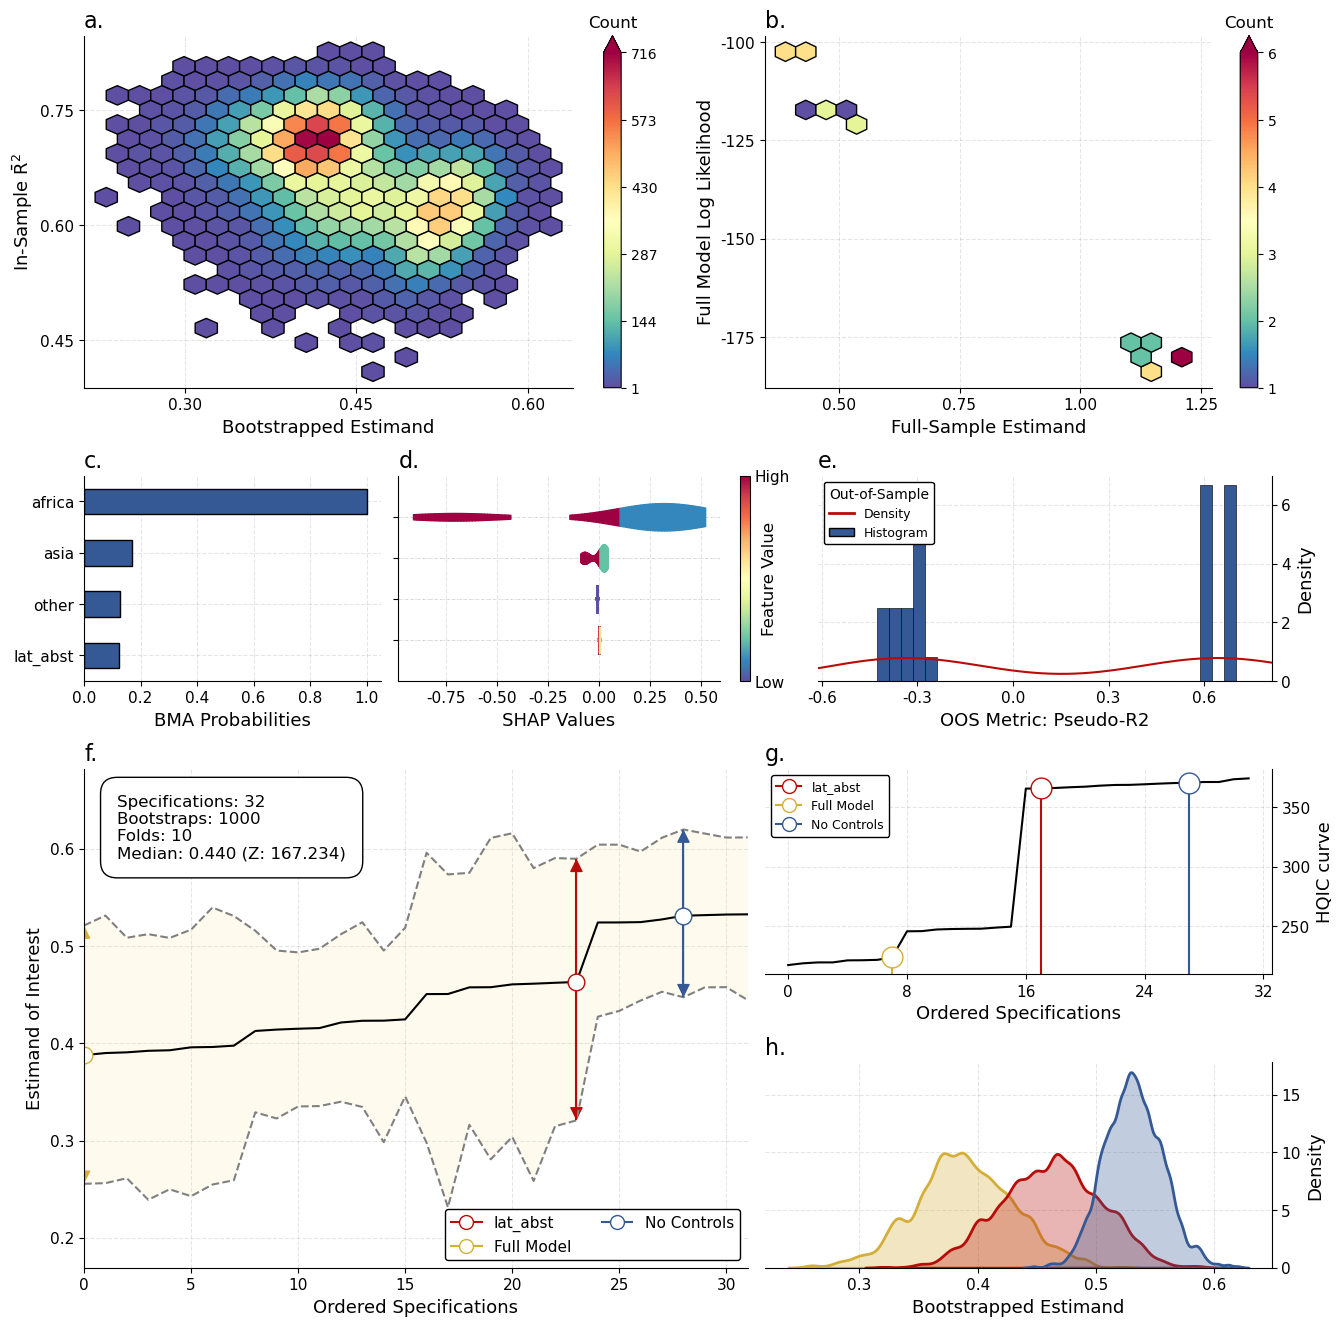

In [14]:
acemoglu_robust_wc_results.plot(specs=[['lat_abst']],
                                ic='hqic',
                                ext='pdf',
                                ci=1,
                                loess=False,
                                figpath = '../figures',
                                project_name='acemoglu_example_w_variable_constant',
                                figsize=(16, 16)
                               )

In [15]:
acemoglu_robust_wc_results.summary(digits=2)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: logpgp95
Independent variable: avexpr
Number of possible controls: 5
Number of draws: 1000
Number of folds: 10
Number of specifications: 32
2.Model Robustness Metrics
2.1 Inference Metrics
Median β (specs, no resampling): 0.81 (null-calibrated p: 0)
Median β (bootstraps × specs): 0.44
Min β (specs, no resampling): 0.39
Min β (bootstraps × specs): 0.23
Max β (specs, no resampling): 1.23
Max β (bootstraps × specs): 0.62
AIC-weighted β (specs, no resampling): 0.40
BIC-weighted β (specs, no resampling): 0.42
HQIC-weighted β (specs, no resampling): 0.41
Share significant (specs, no resampling) [descriptive]: 1.00
Share significant (bootstraps × specs) [descriptive]: 1.00  |  null-calibrated p: 0.002
Share β>0 (specs, no resampling) [descriptive]: 1.00
Share β>0 (bootstraps × specs) [descriptive]: 1.00  |  null-calibrated p: 0.002
Share β<0 (specs, no resampling) [descriptive]: 0.00
Share β<0 (bootstraps × specs) [de